# Tarea 1: Introduction to Machine Learning. 
### JOSÉ IGNACIO ORTEGA LABRA

fecha de entrega: 22 de octubre de 2019

Código de honor: En esta tarea pueden discutir las formas de resolver los ejercicios con compañeros, ayudantes y profesores. Sin embargo, queda estrictamente prohibido compartir o mostrar código a otros compañeros. Esto será considerado como copia y se evaluará con nota mínima.

## Ejercicio 1

Utilizando la información del paper [A Framework for Evaluating Land Use and Land Cover Classification Using Convolutional Neural Networks](https://www.researchgate.net/publication/330747101_A_Framework_for_Evaluating_Land_Use_and_Land_Cover_Classification_Using_Convolutional_Neural_Networks), cree una matriz de diseño (X) que contenga 120 muestras. Para generar dichas muestras, recorte 30 bloques 5x5x3 pixeles (tres representa la profundidad) y luego aplique 4 rotaciones a cada uno de los bloques. Asegúrese que las categorías queden balanceadas (**20 puntos**). Para generar el vector de respuestas (y), proceda tal cual como lo indica el artículo (**5 puntos**). Finalmente, ajuste el modelo utilizando 5-folds cross-validation por medio del algoritmo multinomial logit (**15 puntos**). Finalmente, muestre los resultados de f1-score, precisión y recall, de cada uno de los folds, tanto en training como en testing (**10 puntos**).


##### Crear false color composite image

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
#leer imagen para generar false color composite image
imagen=io.imread('data_joseortega/19920612_AVIRIS_IndianPine_Site3.tif')
#print('Array original Indian Pines:\n ', imagen)

In [3]:
b,y,x = imagen.shape  #dimensiones de la matriz b: profundidad, y: height(altura), x: weight(ancho)
print('Dimensiones Originales:',imagen.shape)
print('Alto:', y)  #alto (h)
print('Ancho', x)  #ancho (w)
print('Profundidad(cantidad de bandas:',b) #profundidad, mapa de color tiene 220 bandas, imagen hiperespectral

Dimensiones Originales: (220, 145, 145)
Alto: 145
Ancho 145
Profundidad(cantidad de bandas: 220


In [4]:
#busco transformar las dimensiones de la matriz, dejando la profundidad como tercer componente.
from sklearn.preprocessing import MinMaxScaler

escalar = MinMaxScaler()

imagen_transformada = escalar.fit_transform(imagen.reshape((b, y * x)).T)
imagen_transformada = imagen_transformada.reshape(y,x,b)
print('Dimensiones imagen transformada:',imagen_transformada.shape)
#print(imagen_transformada)

Dimensiones imagen transformada: (145, 145, 220)


In [5]:
imagenfinal = imagen_transformada[:,:,[29,19,9]]
print('Dimensiones Indian Pines, False Color', imagenfinal.shape)
#print('Array de Indian Pines, False Color', imagenfinal)

Dimensiones Indian Pines, False Color (145, 145, 3)


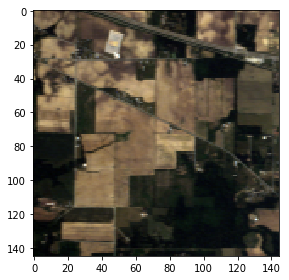

In [6]:
io.imshow(imagenfinal)

##### ground truth

In [7]:
#Se imprime la imagen de la clasificación, hecha por 3 bandas RBG
#Solo con fines de mostrar la clasificación
imagen_truth=io.imread('data_joseortega/19920612_AVIRIS_IndianPine_Site3.tif')

imagen_truth=io.imread('data_joseortega/19920612_AVIRIS_IndianPine_Site3_gr.tif')/65280
print('Dimensiones de ground truth: ',imagen_truth.shape)
#print(imagen_truth)

Dimensiones de ground truth:  (145, 145, 3)


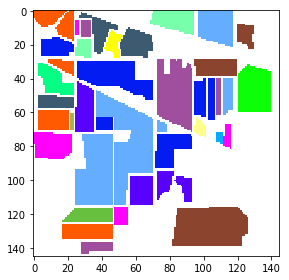

In [8]:
io.imshow(imagen_truth)

##### Imagen de respuesta, 16 clases posibles

In [9]:
#leer matriz de respuesta y de 145x145 donde cada pixel es una clasificación en una de las 16 clases posibles
imagen_clase = np.loadtxt('data_joseortega/indian_pines_site3_gr.txt')
print('Dimensiones de matriz de respuesta y clasificada en cada clase',imagen_clase.shape)
print('\nMatriz de respuesta\n',imagen_clase)

Dimensiones de matriz de respuesta y clasificada en cada clase (145, 145)

Matriz de respuesta
 [[3. 3. 3. ... 0. 0. 0.]
 [3. 3. 3. ... 0. 0. 0.]
 [3. 3. 3. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


##### Generación de 120 muestras balanceadas

In [10]:
def elegir_pixel_aleatorio(matriz_c,valor):
    matriz_coordenadas=[]  #inicializar matriz donde se guardan las coordenas
    matriz = matriz_c[0:141,0:141] #dejar el borde para que se pueda eleguir el PIXEL SUPERIOR, menos 2 pixel cada extremo
    for i in range(matriz.shape[0]):
        for j in range(matriz.shape[1]):
            if(matriz[i][j] == valor):   #recorrer la matriz y comprar cada elemento si es el que yo busco
                matriz_coordenadas = np.append(matriz_coordenadas,np.array([i,j])) #guardo las coordenadas que cumplen 
    matriz_coordenadas = matriz_coordenadas.reshape(int(len(matriz_coordenadas)/2),2) #martriz de (x,2)
    coor_x = np.random.randint(0,matriz_coordenadas.shape[0]) #eligo la coordenada i aleatoria
    return matriz_coordenadas[coor_x][:] #se imprime la coordenada i asociada a su j como array(2,)

def elegir_muestra(matriz_x,matriz_y, valor):
    pixel_superior = elegir_pixel_aleatorio(matriz_y,valor)
    x_superior = int(pixel_superior[0])  #creo pixel x superior
    y_superior = int(pixel_superior[1])   #creo pixel y superior
    muestra_y = np.array([matriz_y[x_superior+i,y_superior+j] for i in range(5)
                        for j in range(5)]).reshape(5,5) #creo matriz 5x5 con los valores
    #obtener matriz x asociada
    muestra_x = np.array([matriz_x[x_superior+i,y_superior+j,:] for i in range(5)
                        for j in range(5)]).reshape(5,5,3) #creo matriz 5x5 con los valores
    return muestra_x,muestra_y
   
def conjunto_muestra(matriz_x,matriz_y):
    muestra_final_x = []
    muestra_final_y = []
    #creación de muestra aleatoria verificando que este balanceada a traves del pixel superior que se elige
    for i in range(17):  
        matriz_x_aux, matriz_y_aux = elegir_muestra(matriz_x,matriz_y,i)
        for j in range(4):
            matriz_x_aux_rot = np.rot90(matriz_x_aux,j)
            matriz_y_aux_rot = np.rot90(matriz_y_aux,j)
            muestra_final_x = np.append(muestra_final_x,matriz_x_aux_rot)
            muestra_final_y = np.append(muestra_final_y,matriz_y_aux_rot)
          
    for i in range(13):
        matriz_x_aux, matriz_y_aux = elegir_muestra(matriz_x,matriz_y,i)
        for j in range(4):
            matriz_x_aux_rot = np.rot90(matriz_x_aux,j)
            matriz_y_aux_rot = np.rot90(matriz_y_aux,j)
            muestra_final_x = np.append(muestra_final_x,matriz_x_aux_rot)
            muestra_final_y = np.append(muestra_final_y,matriz_y_aux_rot)
        
    
    return muestra_final_x.reshape((120,5,5,3)), muestra_final_y.reshape((120,5,5))

In [11]:
matriz_x,matriz_y = conjunto_muestra(imagenfinal, imagen_clase)
print('matriz x',matriz_x.shape)
print('matriz y',matriz_y.shape)

matriz x (120, 5, 5, 3)
matriz y (120, 5, 5)


In [12]:
counter = 0
while counter<120:
    valor_sup_izq = matriz_y[counter,0,0]
    print('Clase muestra', counter+4, ': ', valor_sup_izq)
    print(matriz_y[counter], '\n')
    counter = counter + 4
    

Clase muestra 4 :  0.0
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]] 

Clase muestra 8 :  1.0
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1.]] 

Clase muestra 12 :  2.0
[[2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]] 

Clase muestra 16 :  3.0
[[3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3.]] 

Clase muestra 20 :  4.0
[[4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4.]
 [0. 0. 0. 0. 0.]] 

Clase muestra 24 :  5.0
[[5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5.]] 

Clase muestra 28 :  6.0
[[6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6.]
 [6. 6. 6. 6. 6.]] 

Clase muestra 32 :  7.0
[[7. 5. 5. 5. 5.]
 [7. 5. 5. 5. 5.]
 [7. 5. 5. 5. 5.]
 [0. 5. 5. 5. 5.]
 [0. 0. 5. 5. 5.]] 

Clase muestra 36 :  8.0
[[8. 8. 8. 8. 8.]
 [8. 8. 8. 8. 8.]
 [8. 8

In [13]:
counter2 = 0
cont_clases = np.zeros(17)
while counter2<120: 
    for i in range (5):
        for j in range (5):
            valor_pixel = matriz_y[counter2,i,j]
            for k in range(17):
                #print(counter2, i, j, valor_pixel)
                if(k == valor_pixel):
                    cont_clases[k] += 1
    counter2 = counter2 + 4
                    
for k in range(17):
    print('Cantidad de pixeles clase ', k, ': ',cont_clases[k])       

Cantidad de pixeles clase  0 :  161.0
Cantidad de pixeles clase  1 :  44.0
Cantidad de pixeles clase  2 :  52.0
Cantidad de pixeles clase  3 :  65.0
Cantidad de pixeles clase  4 :  45.0
Cantidad de pixeles clase  5 :  65.0
Cantidad de pixeles clase  6 :  61.0
Cantidad de pixeles clase  7 :  7.0
Cantidad de pixeles clase  8 :  50.0
Cantidad de pixeles clase  9 :  10.0
Cantidad de pixeles clase  10 :  50.0
Cantidad de pixeles clase  11 :  45.0
Cantidad de pixeles clase  12 :  32.0
Cantidad de pixeles clase  13 :  5.0
Cantidad de pixeles clase  14 :  23.0
Cantidad de pixeles clase  15 :  25.0
Cantidad de pixeles clase  16 :  10.0


##### Observación:
Se verifica que la muestra está balanceada eligiendo el pixel superior izquierdo de cada muestra y que este pixel tome todos los valores de clases, es decir, se pide que el pixel superior izquierdo de la muestra 1 tome valor 1 eleguido de forma aleatoria de todos los pixeles que cumplen esa condición y así para el resto de muestra hasta recorrer todas las clases posibles de la matriz de respuesta Y.


##### 5-folds cross-validation with multinomial logit

In [22]:
def five_fold (X,y):

    #llamo a la clase KFold, diviendo la muestra en 5 conjuntos y que NO se reordenen aleatoriamente los datos
    five_fold = KFold(n_splits=5, shuffle=False)
    model_mnl = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
    num = 0
    
    print(X.shape)
    print(y.shape)
    for indice_train, indice_test in five_fold.split(X, y):
        num += 1
        print('\n-------Fold  ',num,'-------\n')
        #print('INDICE TRAIN',indice_train)
        #print('INDICE TRAIN',indice_train)
        
        #CAMBIO LA DIMENSIÓN A VECTOR Y [96,25,1], MATRIZ X [96,25,3] Y voy leyendo cada muestra de train
        #necesito poner todas las muestras hacia abajo, entonces, X[2400,3] y[2400,1]
        X_train = X[indice_train].reshape((2400,3))
        y_train = y[indice_train].reshape((2400,1))
        print(X_train.shape)
        print(y_train.shape)
        #Cambio dimensión de vector X en muestra de testeo a [24,25,3] y matriz a dimensión [24,25,1]
         #necesito poner todas las muestras hacia abajo, entonces, X[600,3] y[600,1]
        X_test = X[indice_test].reshape((600,3))
        y_test = y[indice_test].reshape((600,1))
        print(X_test.shape)
        print(y_test.shape)
        
        #Ajustar modelo
        model_mnl.fit(X_train, y_train)  
        
        
        #Predicciones del modelo
        y_train_pred = model_mnl.predict(X_train)
        y_test_pred = model_mnl.predict(X_test)
        
            
        #Si se desea se puede mostrar los coeficientes        
        #print('Intercepto del modelo:\n',model_mnl.intercept_)
        #print('\nCoeficientes del modelo:\n',model_mnl.coef_)
        
        
        print('--Mediciones conjunto TRAIN--')
        print('Precision: ', precision_score(y_train, y_train_pred,average='macro'))
        print('Recall: ', recall_score(y_train, y_train_pred,average='macro'))
        print('F1: ', f1_score(y_train, y_train_pred,average='macro'))
        
        
        print('\n--Mediciones conjunto de TEST--')
        print('Precision: ', precision_score(y_test, y_test_pred,average='macro'))
        print('Recall: ', recall_score(y_test, y_test_pred,average='macro'))
        print('F1: ', f1_score(y_test, y_test_pred,average='macro'))
        

In [23]:
#SOLUCION
five_fold(matriz_x,matriz_y)


(120, 5, 5, 3)
(120, 5, 5)

-------Fold   1 -------

(2400, 3)
(2400, 1)
(600, 3)
(600, 1)
--Mediciones conjunto TRAIN--
Precision:  0.07665672720701183
Recall:  0.13712660067529886
F1:  0.0954123131417748

--Mediciones conjunto de TEST--
Precision:  0.03316326530612245
Recall:  

C:\Users\joseo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\joseo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joseo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.11981566820276499
F1:  0.05194805194805195

-------Fold   2 -------

(2400, 3)
(2400, 1)
(600, 3)
(600, 1)
--Mediciones conjunto TRAIN--

C:\Users\joseo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Precision:  0.08329055741143955
Recall:  0.14547787768789724
F1:  0.10282292054091856

--Mediciones conjunto de TEST--
Precision:  0.0071111111111111115
Recall:  0.1111111111111111
F1:  0.013366750208855471

-------Fold   3 -------

(2400, 3)
(2400, 1)
(600, 3)
(600, 1)
--Mediciones conjunto TRAIN--
Precision:  0.14021080924029264
Recall:  0.20048548381101075
F1:  0.15789871969418673

--Mediciones conjunto de TEST--
Precision:  0.08796296296296297
Recall:  0.05535714285714286
F1:  0.06793478260869566

-------Fold   4 -------

(2400, 3)
(2400, 1)
(600, 3)
(600, 1)


C:\Users\joseo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joseo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joseo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\joseo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and be

--Mediciones conjunto TRAIN--
Precision:  0.14893566443456802
Recall:  0.21073306282859952
F1:  0.16672621407926155

--Mediciones conjunto de TEST--
Precision:  0.05045760936171895
Recall:  0.15759759759759762
F1:  0.06697599299225315

-------Fold   5 -------

(2400, 3)
(2400, 1)
(600, 3)
(600, 1)
--Mediciones conjunto TRAIN--
Precision:  0.12366354535456354
Recall:  0.11905549693273479
F1:  0.09141178315551973

--Mediciones conjunto de TEST--
Precision:  0.07064566639034724
Recall:  0.11515151515151514
F1: 

C:\Users\joseo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joseo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\joseo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\joseo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and be

 0.06407389402041809


## Ejercicio 2

En esta sección trabajaremos con un set de datos real, extraido de [Kaggle](https://www.kaggle.com/mauryashubham/linear-regression-to-predict-market-value), una plataforma que funciona como crowd-sourcing y contiene desafíos relacionados con ciencia de datos (¡Es el gimnasio de los data scientis!).

En este set de datos se tiene información acerca de los jugadores de la Premier League Inglesa. El objetivo es ser capaces de ajustar un modelo que prediga el valor de mercado de cada jugador. Se cuenta con la siguiente información:

`name`: Nombre del jugador.  
`club`: Club del jugador.  
`age` : Edad del jugador.  
`position` : Posición usual del jugador en el campo.  
`position_cat` : 1 para delanteros, 2 para mediocampos, 3 para defensores, 4 para arqueros.  
`market_value` : Precio de mercado dado por transfermrkt.com en 20 de julio de 2017.  
`page_views` : Número promedio de búsquedas de wikipedia desde el 1 de septiembre del 2016 hasta 1 de mayo de 2017.  
`fpl_value` : Valor del jugador en la Fantasy Premier League el 20 de julio de 2017.  
`fpl_sel` : % de jugadores de Fantasy Premier League que han escogido a ese jugador en su equipo.  
`fpl_points` : puntos acumulados en Fantasy Premier League dentro de la temporada previa.  
`region`: 1 para Inglaterra, 2 para Union Europea, 3 para America, 4 para el resto del mundo.  
`nationality`: Nacionalidad del jugador.  
`new_foreign`: Si tiene un fichaje para una liga distinta para el año 2018.  
`age_cat`: Version categorica de la edad.  
`club_id`: Versión categorica para el club.  
`big_club`: Si el jugador está dentro de los 6 mejores club.  
`new_signing`: Whether a new signing for 2017/18 (till 20th July.


#### PREGUNTA 2.1


Para empezar comenzaremos por importar los datos y hacer una breve descripción de ellos, de manera de entender con lo que estamos tratando.

2.1 Importe los datos utilizando la librería Pandas e imprima sus primeras 5 filas (**2 puntos**).

In [21]:
premier_dt = pd.read_csv("data_joseortega/premier.csv") #lectura archivo datos
premier_dt.head() #función imprime los primeros 5 datos del dataframe


,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,12.0,17.10%,264,3.0,Chile,0,4,1,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,9.5,5.60%,167,2.0,Germany,0,4,1,1,0
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,5.5,5.90%,134,2.0,Czech Republic,0,6,1,1,0
3,Theo Walcott,Arsenal,28,RW,1,20.0,2393,7.5,1.50%,122,1.0,England,0,4,1,1,0
4,Laurent Koscielny,Arsenal,31,CB,3,22.0,912,6.0,0.70%,121,2.0,France,0,4,1,1,0


In [22]:
#EXTRA
premier_dt.shape  #tamaño de la base de datos, 461 jugadores evaluados

(461, 17)

#### PREGUNTA 2.2

2.2.1 Hagamos una descripción de los datos. Para cada una de las posiciones de cada jugador (position), se pide encontrar el promedio de precio de mercado (market value), el promedio de busquedas en wikipedia (page views) y el promedio de puntos acumulados en la Fantasy Premier Leage (fpl_points) (**5 puntos**).

2.2.2 Segreguemos aún más nuestros datos. Para clubes grandes y clubes chicos (big_club) y para cada posición (position), queremos encontrar  el promedio de precio de mercado (market value), el promedio de busquedas en wikipedia (page views) y el promedio de puntos acumulados en la Fantasy Premier Leage (fpl_points). Esto debiese verse de la siguiente forma:

| big_club  | position  | market_value  |  page_views | fpl_points  |
|---|---|---|---|---|
|  0 | AM  | x  |  y |  z |
| ...  |  ... | ...  | ...  | ...  |
|  1 |  AM | x'  | y'  | z'  |
| ...  |  ... | ...  | ...  | ...  |


Sin embargo, la presentación de sus resultados puede ir en el orden que usted estime conveniente mientras se encuentre toda la información requerida (**5 puntos**).  
2.2.3 ¿Podemos extraer alguna conclusión previa a través de este análisis descriptivo? ¿Qué tipo de jugadores son los que mayor valor de mercado tienen? ¿Tiene alguna influencia el tamaño en el club respecto al precio de mercado de cada jugador?  (**3 puntos**)

$\textit{Hint}$: Ambos ejercicios pueden realizarse en sólo una linea de código utilizando la función Groupby de Pandas.

In [23]:
#Pregunta 2.2.1

#pd.pivot_table(premier_dt, index = 'position' , values = ['market_value', 'page_views', 'fpl_points' ], aggfunc = 'mean')
premier_dt.groupby('position').agg({'market_value':'mean', 'page_views':'mean','fpl_points':'mean'})

,market_value,page_views,fpl_points
position,,,
AM,26.161765,1455.294118,107.764706
CB,8.972353,491.411765,49.847059
CF,13.823770,1257.491803,61.704918
CM,10.960317,785.761905,50.603175
DM,12.347222,745.250000,50.527778
GK,7.234524,522.166667,56.380952
LB,8.300000,439.371429,54.485714
LM,4.000000,422.500000,45.750000
LW,13.293056,972.888889,66.333333


In [24]:
#Pregunta 2.2.2

#pd.pivot_table(premier_dt, index = ['big_club','position'] , values = ['market_value', 'page_views', 'fpl_points' ], aggfunc = 'mean')
premier_dt.groupby(['big_club','position']).agg({'market_value':'mean', 'page_views':'mean','fpl_points':'mean'})

market_value   page_views  fpl_points
big_club position                                       
0        AM           13.861111   574.555556   70.333333
         CB            4.646610   299.169492   43.644068
         CF            8.215116   801.534884   51.906977
         CM            5.944444   349.177778   39.400000
         DM            7.795455   443.772727   44.272727
         GK            4.401786   375.214286   52.821429
         LB            4.937500   249.708333   47.791667
         LM            3.857143   349.142857   48.571429
         LW            6.500000   430.958333   48.083333
         RB            4.550000   278.200000   50.320000
         RM            4.333333   280.333333    1.666667
         RW            8.086538   573.384615   52.653846
         SS            6.916667  1861.666667   51.500000
1        AM           40.000000  2446.125000  149.875000
         CB           18.788462   927.653846   63.923077
         CF           27.222222  2346.722222   85.111111
         CM           23.500000  1877.222222   78.611111
         DM           19.500000  1219.000000   60.357143
         GK           12.900000   816.071429   63.500000
         LB           15.636364   853.181818   69.090909
         LM            5.000000   936.000000   26.000000
         LW           26.879167  2056.750000  102.833333
         RB           16.611111   974.222222   90.888889
         RM           20.000000  2028.000000   94.000000
         RW           30.000000  1324.166667   71.000000
         SS           38.000000  2196.000000  180.000000

In [25]:
#EXTRA. Datos segregados de acuerdo a las 4 clasificaciones de posición, 1:arquero, 2:defensa, 3:medio, 4:delantero
premier_dt.groupby(['big_club','position_cat']).agg({'market_value':'mean', 'page_views':'mean','fpl_points':'mean'})


market_value   page_views  fpl_points
big_club position_cat                                       
0        1                 8.130734   699.752294   52.266055
         2                 6.220779   373.519481   40.155844
         3                 4.728037   283.962617   46.542056
         4                 4.401786   375.214286   52.821429
1        1                30.012222  2147.377778  101.577778
         2                21.171429  1595.657143   70.685714
         3                17.608696   918.956522   70.434783
         4                12.900000   816.071429   63.500000

RESPUESTA Pregunta 2.2.3

Observando los datos se puede concluir en primer lugar que los jugadores pertenecientes a clubes grandes tienen mayor valor de mercado, por lo tanto el tamaño del club al que pertencer sí juega un rol importante en el valor de mercado de éstos. Del mismo modo para las otras dos estadísticas analizadas los puntos en el fantasy premier league, y número de visitas en wikipedia se tiene que los jugadores de clubes grandes poseen calificaciones mejores y más visitas que sus pares de la misma posición que jueguen en clubes más chicos.

Analizando de forma específica por posición se tiene que AM,SS,RW Y CF por lo general son los que tiene un mayor valor de mercado tanto para clubes grandes como pequeños y que además este mayor valor de mercado se traduce en la mayoría de los casos en puntuaciones altas tanto en las puntaciones del fantasy como en su número de visitas.

Además, viendo el gráfico extra los jugadores de posición delantero son los que tiene mayor valor de mercado seguidos por medio campistas, defensas y en último lugar arqueros, y como es tónica estos valores son mayores para los clubes grandes que para los pequeños.




#### PREGUNTA 2.3

2.3 Utilice la función `train_test_split` de scikit-learn para dividir este conjunto de datos en entrenamiento y test. Luego haga un histograma del valor de mercado para el conjunto de entrenamiento y test. ¿Son estos histogramas similares? Si lo son  ¿es esto bueno para realizar una regresión? Si no lo son ¿En qué podría afectar esto al resultado final de una regresión? (**3 puntos**)

In [26]:
from sklearn.model_selection import train_test_split
#set_train, set_test = train_test_split(premier_dt, test_size = 0.3)    #cada vez que se ejecuta toma una muestra diferente

set_train, set_test = train_test_split(premier_dt,test_size = 0.3, shuffle = False) 

#tamaño de muestra de test, 30% de los datos cada vez que se ejecuta toma la misma muestra sin desordenar

#Se busca que sea la misma base de datos siempre solo para que se pueda ejecutar en diferentes computadores y diferentes
#días y se puedan obtener los mismos resultados, por ejemplo, para la pregunta 2.6 los errores varian demasiado 
#dependiendo la aleatoriedad de la base de datos, por lo tanto, es mejor una muestra fija y poder obtener siempre los mismos 
#resultados y sea así más fácil de explicar '''

In [27]:
#información
print("Tamaño conjunto de entrenamiento",set_train.shape)
print("Tamaño conjunto de testeo",set_test.shape)
print("Tamaño conjunto Total",premier_dt.shape)

Tamaño conjunto de entrenamiento (322, 17)
Tamaño conjunto de testeo (139, 17)
Tamaño conjunto Total (461, 17)


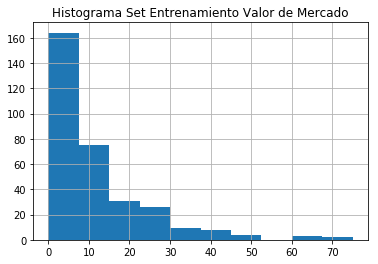

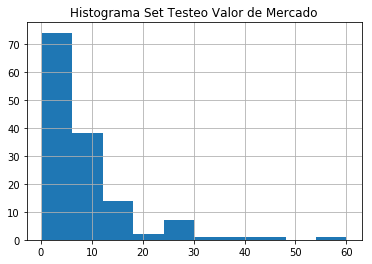

In [28]:
#histograma
plt.title('Histograma Set Entrenamiento Valor de Mercado')
plt.hist(set_train.market_value)
plt.grid()
plt.show()

plt.title('Histograma Set Testeo Valor de Mercado')
plt.hist(set_test.market_value)
plt.grid()
plt.show()

In [29]:
#ejemplo visualización set de entrenamiento
set_train.head()

,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,12.0,17.10%,264,3.0,Chile,0,4,1,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,9.5,5.60%,167,2.0,Germany,0,4,1,1,0
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,5.5,5.90%,134,2.0,Czech Republic,0,6,1,1,0
3,Theo Walcott,Arsenal,28,RW,1,20.0,2393,7.5,1.50%,122,1.0,England,0,4,1,1,0
4,Laurent Koscielny,Arsenal,31,CB,3,22.0,912,6.0,0.70%,121,2.0,France,0,4,1,1,0


Como se puede observar los histogramas son similares, con una mayor cantidad de jugadores con sueldos entre 0 y 30. Así, estos resultados son buenos para la realización de una regresión, ya que al ser datos similares tanto en el set de entrenamiento y testo se van a obtener resultados similares comprobando así la validez del modelo estimado, ya que si hubieran sido conjuntos de datos muy diferentes, en el set de entrenamiento el algoritmo de regresión se hubiera ajustado solo a estos datos produciendo una sobreestimación ya que no seria válido, entregaría muy malas predicciones, para cualquier otro conjunto de datos.

#### PREGUNTA 2.4

2.4 En esta parte de la tarea intentaremos ajustar una regressión para los datos que describimos anteriormente e interpretar los resultados.
Supóngase una hipótesis que tiene la siguiente forma:

$$market\_value \approx \theta_{0} + \theta_{1}*fpl\_points + \theta_{2}*age + \theta_{3}*age^{2} + \theta_{4} * \log_{2}{page\_views} + \theta_{5} * new_signing + \theta_{6}*big\_club + \theta_{7}*position\_cat$$


Nota: Se incluye $age^{2}$ porque se espera que la paga incremente a medida que el jugador gana experiencia, pero disminuya a medida que el jugador gana más edad. Se incorpora además $\log_{2}{page\_views}$ porque esa columna contiene valores grandes numéricamente y la variable transformada deviese tenes menos outliers que sesgen nuestra predicción.

Para este modelo se pide crear la matriz de diseño y ajustar los datos a la hipótesis con una regresión lineal. Evalúe este modelo a través de su conjunto de test. ¿Está este modelo sobreajustado?  (**10 puntos**).


Evaluar los coeficientes de este modelo para las variables:
1. $age$ y $age^{2}$.
2. $\log_{2}{page\_views}$
3. Big club.

¿Qué valor tienen estos coeficientes? ¿Qué significa el valor de estos coeficientes respecto a nuestra variable de respuesta? (**10 puntos**).


In [30]:
from sklearn.linear_model import LinearRegression

#añadir edad al cuadrado al dataframe
set_train['age2'] = set_train['age']**2
set_test['age2'] = set_test['age']**2

#añadir log2 de visitas al dataframe 
set_train['log2_page']= np.log2(set_train['page_views'])
set_test['log2_page'] = np.log2(set_test['page_views'])

C:\Users\joseo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\joseo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\joseo\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.

In [31]:
#ejemplo de visualización set de entrenamiento
set_train.head()

,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing,age2,log2_page
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,12.0,17.10%,264,3.0,Chile,0,4,1,1,0,784,12.079818
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,9.5,5.60%,167,2.0,Germany,0,4,1,1,0,784,12.101647
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,5.5,5.90%,134,2.0,Czech Republic,0,6,1,1,0,1225,10.578373
3,Theo Walcott,Arsenal,28,RW,1,20.0,2393,7.5,1.50%,122,1.0,England,0,4,1,1,0,784,11.224605
4,Laurent Koscielny,Arsenal,31,CB,3,22.0,912,6.0,0.70%,121,2.0,France,0,4,1,1,0,961,9.832890


In [32]:
#CONJUNTOS DE ENTRENAMIENTO A SER MODELADOS, sólo con los datos que interesan que formen parte de la regresión
y_train = set_train['market_value']

X_train = set_train[['fpl_points','age','age2', 'log2_page', 'new_signing',
           'big_club', 'position_cat']]

In [33]:
#matriz de diseño de los datos, vector X de los datos más columna de datos unitario que acompaña al intercepto de la regresión
matriz_X_train = np.array(X_train)
print('Tamaño original del vector de entrenamiento: ',matriz_X_train.shape)
print('Tamaño del vector unitario:',np.ones((matriz_X_train.shape[0],1)).shape)


matriz_diseño = np.hstack((np.ones((matriz_X_train.shape[0],1)),matriz_X_train))

print('Tamaño de la matriz de diseño:',matriz_diseño.shape)

Tamaño original del vector de entrenamiento:  (322, 7)
Tamaño del vector unitario: (322, 1)
Tamaño de la matriz de diseño: (322, 8)


In [34]:
print('Visualización Matriz de diseño en numpy')
matriz_diseño

Visualización Matriz de diseño en numpy


array([[  1., 264.,  28., ...,   0.,   1.,   1.],
       [  1., 167.,  28., ...,   0.,   1.,   1.],
       [  1., 134.,  35., ...,   0.,   1.,   4.],
       ...,
       [  1.,  40.,  23., ...,   1.,   0.,   1.],
       [  1.,  38.,  26., ...,   0.,   0.,   2.],
       [  1.,  38.,  21., ...,   1.,   0.,   2.]])

In [35]:
print('Visualización Matriz de diseño en pandas, DataFrame')  
pd.DataFrame(matriz_diseño)
#Observación se pierde el índice original, aquí no se puede observar porque se tomaron los datos por orden

Visualización Matriz de diseño en pandas, DataFrame


,0,1,2,3,4,5,6,7
0,1.0,264.0,28.0,784.0,12.079818,0.0,1.0,1.0
1,1.0,167.0,28.0,784.0,12.101647,0.0,1.0,1.0
2,1.0,134.0,35.0,1225.0,10.578373,0.0,1.0,4.0
3,1.0,122.0,28.0,784.0,11.224605,0.0,1.0,1.0
4,1.0,121.0,31.0,961.0,9.832890,0.0,1.0,3.0
5,1.0,119.0,22.0,484.0,10.709945,0.0,1.0,3.0
6,1.0,116.0,30.0,900.0,11.122828,0.0,1.0,1.0
7,1.0,115.0,31.0,961.0,9.116344,0.0,1.0,3.0
8,1.0,90.0,25.0,625.0,10.874213,1.0,1.0,3.0
9,1.0,89.0,21.0,441.0,10.823367,0.0,1.0,1.0


In [36]:
#regresión lineal
#Ajuste de los datos de entranamiento con una regresión lineal, al ser una función de sklearn calcula internamente la 
#matriz de diseño hecha anteriormente.

model = LinearRegression()
model.fit(X_train,y_train)

#coeficientes de la regresión
print('Intercepto del modelo:',model.intercept_)
print('\nCoeficientes del modelo:',model.coef_)

Intercepto del modelo: -100.77382826558446

Coeficientes del modelo: [ 0.08164622  6.98741752 -0.13558615  2.23471769  3.02986202  8.09494236
 -1.32162614]


In [37]:
#calcular y predicho con el set de entranamiento
y_train_predict = model.predict(X_train)

#calcular y predicho con el set de testeo (calcular conjuntos de testeo solo con los datos que interesan)
y_test = set_test['market_value']
X_test = set_test[['fpl_points','age','age2', 'log2_page', 'new_signing',
           'big_club', 'position_cat']]
y_test_predict = model.predict(X_test)


In [38]:
'''
Una forma de ver overfitting, es decir que el modelo predicho se ajuste demasiado a los datos de entrenamiento y no lo hace
con los datos de testeo es hacerlo a través del R2 y del error cuadrado medio

'''
from sklearn.metrics import r2_score, mean_squared_error
#r2 del conjunto de entrenamiento y de testeo
train_score = r2_score(y_train, y_train_predict)
test_score = r2_score(y_test, y_test_predict)

#error cuadrado medio del conjunto de entrenamiento y de testeo
train_mse = mean_squared_error(y_train, y_train_predict)
test_mse = mean_squared_error(y_test, y_test_predict)

print('Set de Entrenamiento')
print('Entrenamiento MSE: ', train_mse)
print('Entrenamiento R2: ', train_score)
print('\nSet de Testeo')
print('Testeo MSE: ', test_mse)
print('Testeo R2: ', test_score)

Set de Entrenamiento
Entrenamiento MSE:  57.00766161731228
Entrenamiento R2:  0.674058379013166

Set de Testeo
Testeo MSE:  32.089924608450794
Testeo R2:  0.615832073236859


Por lo tanto se puede observar que el R2 tanto de la muestra de entrenamiento como de la muestra de testo son muy cercanos  (siendo el de testeo sólo un poco más bajo), es decir, el modelo se ajusta de igual forma tanto para los datos de entrenamiento como de los datos de testeo, por lo que no existe un sobreajuste de los datos.

Estos tienen un R2 de 0.67 y 0.62 aproximadamente para entrenamiento y testeo correspondientemente y del mismo modo ambos set tiene un error cuadradico medio similar, fundando la afirmación de no existir overfitting en este modelo.

In [39]:
#evaluación de los Coeficientes
Beta_age = model.coef_[1]
Beta_age2 = model.coef_[2]
Beta_log2page = model.coef_[3]
Beta_big_club = model.coef_[5]

print('Coeficientes Beta Age: ', Beta_age)
print('Coeficientes Beta Age2: ', Beta_age2)
print('Coeficientes Beta log2 Page: ', Beta_log2page)
print('Coeficientes Beta Big Club: ', Beta_big_club)

Coeficientes Beta Age:  6.987417522248534
Coeficientes Beta Age2:  -0.13558615194598928
Coeficientes Beta log2 Page:  2.234717689502923
Coeficientes Beta Big Club:  8.094942361186314


##### Respuesta
Es importante destacar que el modelo posee un R2 que varía dependiendo del set de entrenenamiento elegido, el cual en este caso se deja fijo y representa un 70% del total de la base de datos, de forma empírica se detectó que este R2 es por lo general alrededor de 0.67, es decir, un 67% de la variabilidad total de los datos es explicado por el modelo estimado.

La variable de respuesta, el valor de mercado toma valores cada vez más grande si los coeficientes de las variables explicativas son positivos y valores más pequeños si estos son negativos.

Se puede observar que el valor de mercado aumenta a medida que se incrementa la cantidad de visitas en wikipedia de los jugadores, indicado esto por su coeficiente positivo. Esto el lógico de explicar ya que entre más visitas, el jugador es mejor, de más fama y va a tener un valor mayor.

Del mismo modo el jugador tomar un mayor valor de mercado si es de un club grande, (8.09 millones más para ser exactos), indicado por su coeficiente positivo. (Big club es variable binaria que toma valor 1 al ser de club grande).

Por último, al considerar la edad en su conjunto, se tiene una parabola a * edad^2 + b * edad y se puede observar que en este caso el coeficiente que acompaña a la edad al cuadrado es negativo, mientras que el que acompaña a la edad es positivo así se tiene una parábola convexa para poder representar el efecto deseado de que en un momento a medida que aumenta la edad el jugador aumenta su valor hasta llegar a cierto punto máximo de su carrera y que a continuación el incremento de su edad comienza a disminuir su valor de merdado.

#### PREGUNTA 2.5

2.5 Construya una función mini_batch_gradient_descent que encuentre los parámetros de la regresión a través del uso de mini-batch gradient descent como algoritmo de optimización. Para esto utilice las reglas de optimización derivadas en clases. Evalúe este modelo y compárelo con el obtenido ajustando el método de scikit-learn. ¿Son congruentes los resultados? (**8 puntos**).


In [40]:
def mini_batch_gradient_descent (X,y,batch,coeficientes_inicial,Niter,alfa = 0.01):
    '''
    X = matriz de datos, Tamaño: Número de datos x cantidad de variables, incluido vector unitario inicial (Datos , variables)
    y = vector de variables de respuesta. Tamaño: Número de datos x 1 (Datos , 1)
    batch = tamaño del batch de datos a utilizar
    coeficientes = vector de coeficientes inicial aleatorio del modelo. Tamaño: Número de Coeficientes x 1 (Coeficientes , 1)
    Niter = Número de iteraciones a realizar
    alfa = learning rate, valor por defecto 0.01
    '''
    coeficientes = coeficientes_inicial.copy()
    theta_anterior = coeficientes_inicial.copy()
    funcion_costo_anterior = evaluar_costo(X,y,theta_anterior)
    funcion_costo_actual = 0
    
    for l in range (Niter):
        i = 0
        gradiente = []
        while(i<X.shape[0]):
            gradiente = (np.dot(X[i:i+batch].reshape(X.shape[1],batch), np.dot(X[i:i+batch],coeficientes)-y[i:i+batch]))/batch
            coeficientes -= alfa * gradiente.reshape(X.shape[1],1)
            #siguiente conjunto de batch a evaluar
            i += batch
            
        #EVALUAR LA FUNCION DE COSTOS Y TERMINAR ALGORITMO SI SE OBTIENE UNA FUNCION DE COSTOS MAYOR A LA ANTERIOR
        #PASAR EL PUNTO MÍNIMO DE LA CURVA DE COSTOS
        #obs: en algunos casos si se calculara la funcion de costos obtenida al usar algunos batch de la iteracion se obtienen
        #valores de costos mayores que los anteriores, PERO, al terminar la iteracion completa, es decir calcular los 
        #coeficientes con todos los datos, la función de costos con estos parametros finales de la iteración son más bajos.
            
        #evaluar la funcion de costos actual
        funcion_costo_actual = evaluar_costo(X,y,coeficientes)
            
        if (funcion_costo_anterior < funcion_costo_actual):
            #fin algoritmo
            print('Algoritmo converge en ',l, ' iteraciones')
            return theta_anterior
                    
    
        funcion_costo_anterior = funcion_costo_actual.copy()
        theta_anterior = coeficientes.copy()    
                
    print('Algoritmo converge en las ',Niter, ' iteraciones')        
    return coeficientes



def evaluar_costo(XX,yy,coefici):
    y_predict = []
    error = 0
    y_predict = np.dot(XX,coefici)  #y predicho de cada dato 
    error = mean_squared_error(yy, y_predict)  #error cuadrado medio es la función de costos
    return error
    

In [41]:
#Datos para resolver
theta_inicial = np.random.randn(8,1)
print('Conjunto Inicial obtenido aleatoriamente en cada iteración\n',theta_inicial)
matriz_diseño
y_np = np.array(y_train).reshape(len(y_train),1)
alfa = 1e-08
batch = 7 #tamaño del batch
Niter = 1000 #numero iteraciones


#set de testeo en numpy
y_testeo_np = np.array(y_test).reshape(len(y_test),1)
x_testeo_np = np.hstack((np.ones((np.array(X_test).shape[0],1)),np.array(X_test)))


#calcular coeficientes
coef = mini_batch_gradient_descent(matriz_diseño,y_np,batch,theta_inicial,Niter,alfa)
print('\nCoeficientes del modelo:\n', coef)
print('\nR2 del algoritmo, set entrenamiento', r2_score(y_np, np.dot(matriz_diseño,coef)))
print('\nR2 del algoritmo, set testeo', r2_score(y_testeo_np, np.dot(x_testeo_np,coef)))

Conjunto Inicial obtenido aleatoriamente en cada iteración
 [[ 1.57803269]
 [-1.9851945 ]
 [ 1.21044336]
 [ 0.20239791]
 [ 0.60102892]
 [ 0.14421639]
 [ 0.27005304]
 [-2.26569579]]
Algoritmo converge en las  1000  iteraciones

Coeficientes del modelo:
 [[ 2.01834181]
 [-1.64681791]
 [ 1.66558419]
 [ 0.06529223]
 [ 0.89723169]
 [ 1.74337948]
 [ 0.98074866]
 [-1.08690633]]

R2 del algoritmo, set entrenamiento -53.777555148571096

R2 del algoritmo, set testeo -80.58008145921276


In [42]:
print('Conjunto 1 de datos definidos como conjunto base')
theta_base_1 = np.array([[-0.13068448],[0.7477194],[0.12553161],[0.66056858],[1.99355408],[0.20438593],[1.81585972],[1.49084771]])
print(theta_base_1,'\n')

#calcular coeficientes
coef_1 = mini_batch_gradient_descent(matriz_diseño,y_np,batch,theta_base_1,Niter,alfa)
print('\nCoeficientes del modelo:\n', coef_1)
print('\nR2 del algoritmo, set entrenamiento', r2_score(y_np, np.dot(matriz_diseño,coef_1)))
print('\nR2 del algoritmo, set testeo', r2_score(y_testeo_np, np.dot(x_testeo_np,coef_1)))

Conjunto 1 de datos definidos como conjunto base
[[-0.13068448]
 [ 0.7477194 ]
 [ 0.12553161]
 [ 0.66056858]
 [ 1.99355408]
 [ 0.20438593]
 [ 1.81585972]
 [ 1.49084771]] 

Algoritmo converge en  173  iteraciones

Coeficientes del modelo:
 [[-0.76748048]
 [ 0.09324442]
 [-0.48439445]
 [ 0.00262273]
 [ 1.92267719]
 [-0.37301996]
 [ 1.23563002]
 [ 0.88005975]]

R2 del algoritmo, set entrenamiento 0.517885771055624

R2 del algoritmo, set testeo 0.4379234344079347


In [43]:
print('Conjunto 2 de datos definidos como conjunto base')
theta_base_2 = np.array([[ 0.23417349],[-0.72284266],[-0.61426545],[-1.05341418],[ 0.09479576],[ 1.6529255 ],[ 0.22592692],[ 0.11444534]])
print(theta_base_2,'\n')

#calcular coeficientes
coef_2 = mini_batch_gradient_descent(matriz_diseño,y_np,batch,theta_base_2,Niter,alfa)
print('\nCoeficientes del modelo:\n', coef_2)
print('\nR2 del algoritmo', r2_score(y_np, np.dot(matriz_diseño,coef_2)))
print('\nR2 del algoritmo, set testeo', r2_score(y_testeo_np, np.dot(x_testeo_np,coef_2)))

Conjunto 2 de datos definidos como conjunto base
[[ 0.23417349]
 [-0.72284266]
 [-0.61426545]
 [-1.05341418]
 [ 0.09479576]
 [ 1.6529255 ]
 [ 0.22592692]
 [ 0.11444534]] 

Algoritmo converge en  910  iteraciones

Coeficientes del modelo:
 [[ 1.09031291]
 [ 0.15814619]
 [ 0.22010876]
 [-0.01009982]
 [ 0.18768538]
 [ 2.42884418]
 [ 1.09914279]
 [ 0.98013282]]

R2 del algoritmo 0.4473706687785731

R2 del algoritmo, set testeo 0.18273995074445926


##### Comentario pregunta:
Se presentaron 3 evaluaciones distintas con el método heurístico de mini-batch, cada uno con su correspondiente R2. El primero de ellos se obtiene de una solución inicial completamente aleatoria por lo que los valores obtenidos varian cada vez que se corre el bloque de código pudiendo obtenerse resultados muy buenos o muy malos. Por la forma que esta hecho el código se asume que se parte con un learning rate lo suficientemente pequeño para que cuando la función de costos empeore es porque se pasó del punto óptimo de costos y el algoritmo termina.

Los dos resultados mostrados a continuación, son obtenidos a través de buenas soluciones iniciales obteniendose un R2 de 0.51 y 0.45 con los conjuntos de entrenamiento, terminando el algoritmo en 173 y 910 iteraciones respectivamente. Así, al tener una buena solución inicial y un learning rate bien definido se pueden obtener regresiones de una calidad similar a la del método exacto que tuvo un R2 de 0.67 con este mismo conjunto de entrenamiento.

Ahora, al comparar los R2 del conjunto de testeo se observan valores de 0.44 y 0.18 obtenidos a partir de los 2 conjuntos anteriormente explicados y, principalmente el primer conjunto de soluciones obtenidos el más cercano al exacto que tiene un valor de 0.61.

Por lo tanto, cumpliendo la condición de la solución inicial lo suficientemente buena y un learning rate bueno, los resultados obtenidos con la heurística programada son congruentes con el exacto obtenido de sklearn.

#### PREGUNTA 2.6

2.6 Evalúe su algoritmo de mini_batch_gradient_descent utilizando al menos 5 learning rates distintos. Esta evaluación consistirá en un gráfico donde el eje $x$ represente las iteraciones, mientras que el eje $y$ represente el error total del algoritmo, medido sobre el conjunto de test. Entonces, en este gráfico debiesen existir 5 curvas, donde cada curva representa un learning rate distinto ¿Qué podemos concluir de este gráfico? (**4 puntos**).

Nota: No olvidar que las evaluaciones se deben realizar sobre el conjunto de test.  
Nota2: Este gráfico debiese verse como el ejemplo que aparece a continuación:

![Never](erroriter.png)

In [44]:
#FUNCION DE MINI BATCH ANTERIOR EN ESTE CASO SE CALCULA EL TOTAL DE ITERACIONES Y NO SE DETIENE AL LLEGAR A UNA SOLUCION MINIMA
#FUNCION MINI BATCH ANTERIOR MODIFICADA PARA OBTENER EL ERROR CUADRATICO MEDIO EN CADA ITERACIÓN

def mini_modificada (X,y,batch,coeficientes_inicial,Niter,alfa = 0.01):
    coeficientes = coeficientes_inicial.copy()
    error = np.zeros((Niter,1))   #,matriz para guardar el error de cada iteración
    theta_iter_l = 0 
    y_predicho = 0
    
    for l in range (Niter):
        i = 0
        gradiente = []
        while(i<X.shape[0]):
            gradiente = (np.dot(X[i:i+batch].reshape(X.shape[1],batch), np.dot(X[i:i+batch],coeficientes)-y[i:i+batch]))/batch
            coeficientes -= alfa * gradiente.reshape(X.shape[1],1)
            i += batch
         
        theta_iter_l = coeficientes.copy()   #thetas de cada iteración l
        y_predicho = np.dot(X,theta_iter_l)  #y predicho de cada dato en la iteración l
        error[l] = mean_squared_error(y, y_predicho)  #error cuadrado medio de la iteración l
        
    return error
    

In [45]:
#DATOS PARA GRAFICAR
#Parametros fijos
matriz_diseño #matriz X
y_np #vector y de variables de respuesta
batch = 7 #tamaño batch
Niter_n = 1000 #numero iteraciones

#Vector inicial de coeficientes generados de forma aleatoria
theta_base_1 = np.array([[-0.13068448],[0.7477194],[0.12553161],[0.66056858],[1.99355408],[0.20438593],[1.81585972],[1.49084771]])


#5 alfas distintos, ordenados de mayor a menor. Con alfa 1e-08 valor que se obtiene los mejores resultados, con un R2 de 0.5
alpha = np.array([1e-10,1e-09,1e-08,2e-06,2.3e-06])

#calcular Matriz de Errores para cada uno de los 5 alfas, la que se graficará a continuación
ma_error = np.zeros((Niter_n,5))
for i in range(5):
    ma_error[:,i] = np.array(mini_modificada(matriz_diseño,y_np,batch,theta_base_1,Niter,alpha[i])).reshape(Niter_n)

ma_error = np.array(ma_error)

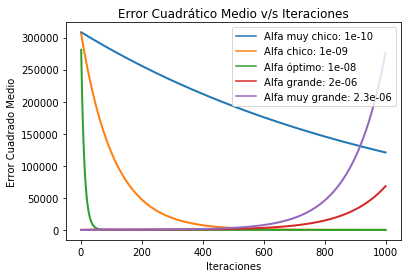

In [46]:
#graficar mil iteraciones
eje_x = np.linspace(1,Niter_n,Niter_n)

lines = plt.plot(eje_x, ma_error[:,0].T, eje_x, ma_error[:,1].T,eje_x, ma_error[:,2].T,eje_x, ma_error[:,3].T,
                 eje_x, ma_error[:,4].T)

plt.legend(('Alfa muy chico: 1e-10', 'Alfa chico: 1e-09', 'Alfa óptimo: 1e-08', 'Alfa grande: 2e-06 ',
            'Alfa muy grande: 2.3e-06'), loc='upper right')
plt.setp(lines[0], linewidth=2)
plt.setp(lines[1], linewidth=2)
plt.setp(lines[2], linewidth=2)
plt.setp(lines[3], linewidth=2)
plt.setp(lines[4], linewidth=2)
plt.title('Error Cuadrático Medio v/s Iteraciones')

plt.xlabel('Iteraciones')
plt.ylabel('Error Cuadrado Medio')

plt.show()


###### Comentario gráfico:
Se puede observar que con un learning rate muy chico (1e-10),línea azul, el error decrece de forma muy lenta a media que se incrementan las iteraciones. Posteriormente con learning rate un poco más grande (1e-09), línea naranja, el error decrece un poco más rápido que con el anterior, pero con un alfa "óptimo" (1e-08), línea verde, el error decrece de forma mucho más rapida debido a que al ser un learning rate mayor, se recorre mayores distancia de la función de costos en la misma cantidad de iteraciones que los alfas anteriores convergiendo en menos iteraciones, mostrando que es un hiperparámetro mejor definido.(De lo expuesto anteriormente se necesitan 173 iteraciones para que converge el algoritmo y este finalize, obteniendo un R2 de 0.52)

Del mismo modo con un learning rate mayor a este óptimo (2e-06), línea roja, se observa que el error disminuye debido a que, como se parte de la misma solución para los 5 hiperparámetros y este alfa al ser mayor alcanza en muy pocas iteraciones el punto óptimo y de la forma en que se definió la función para graficar (no detenerse al llegar a un punto mínimo) posteriormente comienza a aumentar el error escapando del mínimo de la función de costos, mostrando así que es un parámetro mal definido. Finalmente el último alfa (2.3e-06), línea morada, el hiperparámetro más grande de todos es el peor ya que como se observa el error aumenta de forma exponencial al incrementar el número de iteraciones porque recorre grandes distancia de la función de costos rápidamente.

Así se muestra la importancia de poder definir bien un hiperparámetro alfa para poder obtener las mejores soluciones posibles con esta heurística iterativa, ya que si es un valor muy pequeño va a necesitar muchas iteraciones para llegar al óptimo y en cambio si es un alfa muy grande necesita muy pocas iteraciones para encontrar la solución porque como se dijo recorre tramos muy grandes de la función de costos siendo más inexacta y de peor calidad entre más grande es el learning rate.

Por lo tanto la importancia de definir un buen trade-off entre learning rate e iteraciones, y analizar si se quiere una buena solución pero en más iteraciones y tiene de cálculo o algo más inexacto y rápido de obtener.